## **Segundo proyecto - Dataset Properati**

**Obejtivos:** 
- Generar un modelo que tenga un mejor desempeño que el modelo generado en el proyecto anterior.
- Interpretación del modelo: ¿qué podemos aprender de nuestro problema estudiando el modelo que generamos?

**PARTE A - Preprocesamiento de Datos**

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

   1- Detección y eliminación de Outliers  
   2- Encoding  
   3- Imputación de valores faltantes  
   4- Escalado de datos  
   5- Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA)  
   
**PARTE B - Modelos Avanzados**

   1- Elige dos de los modelos avanzados vistos. Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.  
   2- Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.  
   3- Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.  
   
**PARTE C - Interpretación de modelos**

   1- ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?  
   2- ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no?    
   3- ¿Coincide con lo que esperabas a partir de tu experiencia con este dataset?  
   
**Mejor modelo obtenido en el proyecto 1: Árbol de decisión (max_depth = 16)**  
RMSE en Train: 47136.01339635741  
RMSE en Test: 107205.7140916841  

In [119]:
# Importo las librerías a utilizar en todo el proyecto
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
import sklearn.metrics as metrics
import xgboost as xgb
from time import time

from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


pd.options.display.max_columns = None

## <font color=blue>**Parte A: Preprocesamiento de datos**</font> 

In [120]:
#Cargo el dataset
df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
print('El dataset Properati tiene', df.shape[0], 'instancias y', df.shape[1], 'columnas')

# Elijo los tipos de propiedad y localización con las que voy a trabajar el modelo de Machine learning igual que en el proyecto 1
# Se trabaja sobre los tipos de propiedad más frecuentes (Casa, Departamento, PH) en Capital Federal
df = df[((df['property_type'] == 'Departamento') | (df['property_type'] == 'Casa') | (df['property_type'] == 'PH')) & (df['l2'] == 'Capital Federal')]

# Selecciona aquellas propiedades cuya superficie total es menor a 1000 m2 y mayor a 15 m2.
df = df[(df['surface_total'] <= 1000.0) & (df['surface_total'] >= 15.0)]
# Decido aplicar el mismo criterio para surface_covered
df = df[(df['surface_covered'] <= 1000.0) & (df['surface_covered'] >= 15.0)]
# Selecciona aquellas propiedades cuya precio es menor 4000000 dólares.
df = df[df['price'] <= 4000000.0]

# Elimino las columnas que no voy a utilizar en el modelo
# Basado en el proyecto 1, no voy a utilizar la información de estas columnas para el modelo
df = df.drop(['start_date', 'end_date', 'created_on', 'l1', 'currency', 'title', 'lat', 'lon', 'operation_type','description','l2'], axis=1)
print('Shape luego de filtrar tipo de propiedad y localización:', df.shape)
df.head()

El dataset Properati tiene 146660 instancias y 19 columnas
Shape luego de filtrar tipo de propiedad y localización: (81786, 8)


,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH


### <font color=blue>**Encoders**</font> 

Evalúo qué variables son categóricas para convertir a numéricas.

In [121]:
# Evalúo qué atributos son categóricos
print(df.dtypes, '\n')

# Chequeo que trabajo sólo con Casa, Departamento y PH
print(df.property_type.value_counts(),'\n') 

# Cantidad de propiedades por barrio y número de barrios totales en Capital Federal
print('La cantidad de barrios en Capital Federal es:', len(df.l3.unique()))
# print('')
# print('La cantidad de propiedades por barrio es:\n',df.l3.value_counts()) 

l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
property_type       object
dtype: object 

Departamento    69937
PH               9644
Casa             2205
Name: property_type, dtype: int64 

La cantidad de barrios en Capital Federal es: 57


  
**Encoders:**  
1- Transformo property_type a variables numéricas con get_dummies   
2- Transformo l3 a variables numéricas con get_dummies  

De ser necesario, más adelante realizaré reducción de dimensionalidad para mejorar el modelo.

In [122]:
# Transformo las variables categóricas Casa, Departamento, PH a variables dummies
df = pd.concat([df, pd.get_dummies(df.property_type)], axis=1)
df = df.drop('property_type', axis=1)

# Transformo las variables categóricas de l3 a variables dummies
df = pd.concat([df, pd.get_dummies(df.l3)], axis=1)
df = df.drop('l3', axis=1)

df.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### <font color=blue>**Evaluación de las distribuciones de datos de los diferentes atributos**</font> 

Comienzo realizando la descripción, los histogramas y boxplots de las variables para ver su distribución.

In [84]:
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,81786.000000,81786.000000,80949.000000,81786.000000,81786.000000,8.178600e+04,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000
mean,3.007972,2.001003,1.554040,95.299978,82.389932,2.632679e+05,0.026961,0.855122,0.117917,0.005001,0.001895,0.083364,0.029626,0.008388,0.038002,0.073521,0.003362,0.009231,0.070428,0.000061,0.005881,0.007935,0.006236,0.015981,0.007434,0.004671,0.026313,0.010100,0.008437,0.007923,0.006786,0.009060,0.006823,0.022473,0.009060,0.150857,0.002519,0.015553,0.008645,0.003093,0.005319,0.011946,0.002482,0.021079,0.067554,0.009500,0.011579,0.011726,0.008534,0.011652,0.001920,0.001663,0.002592,0.073081,0.015589,0.004059,0.005588,0.006199,0.003118,0.008204,0.001602,0.000416,0.003766,0.000783,0.036216,0.015174
std,1.308775,1.051268,0.852858,77.256320,62.548571,2.981711e+05,0.161969,0.351980,0.322512,0.070540,0.043493,0.276433,0.169555,0.091200,0.191201,0.260992,0.057889,0.095636,0.255868,0.007819,0.076464,0.088727,0.078721,0.125402,0.085900,0.068183,0.160064,0.099988,0.091464,0.088659,0.082098,0.094754,0.082318,0.148218,0.094754,0.357912,0.050124,0.123738,0.092574,0.055533,0.072736,0.108643,0.049759,0.143650,0.250981,0.097006,0.106982,0.107649,0.091988,0.107316,0.043772,0.040745,0.050847,0.260271,0.123881,0.063584,0.074543,0.078490,0.055751,0.090206,0.039990,0.020385,0.061252,0.027963,0.186829,0.122244
min,1.000000,0.000000,1.000000,15.000000,15.000000,6.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.250000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

<AxesSubplot:xlabel='bathrooms'>

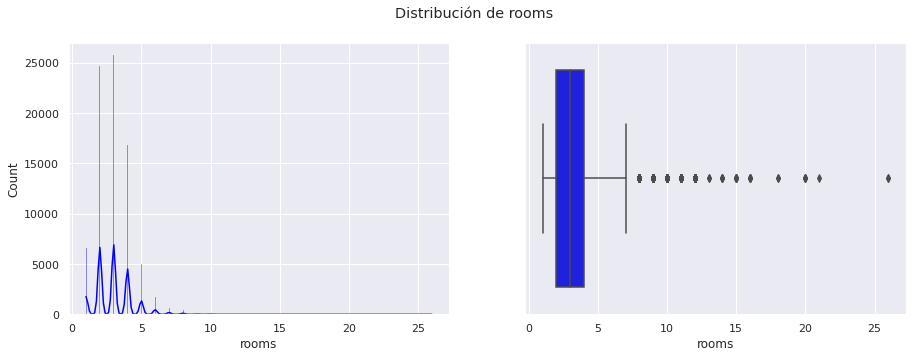

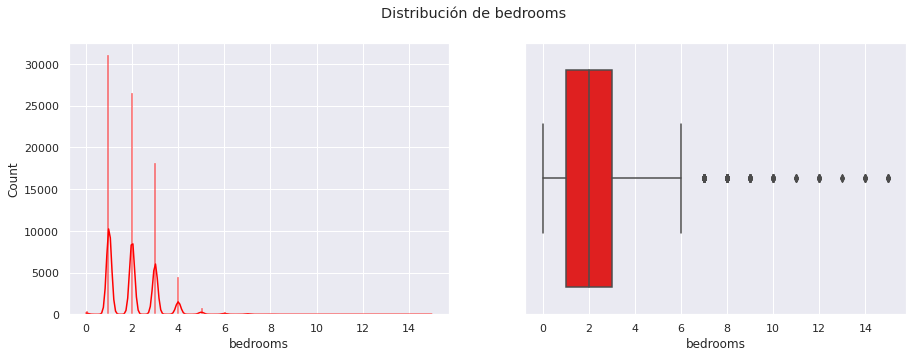

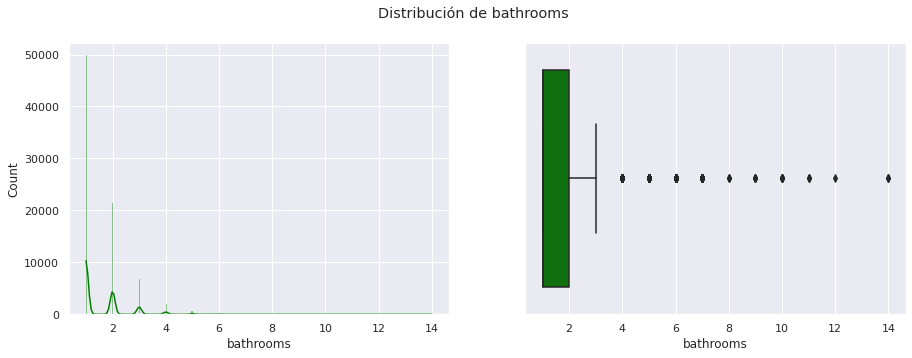

In [85]:
# Rooms
# print(df.rooms.describe())
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de rooms')

sns.histplot(ax=axes[0], x=df.rooms, color="blue", kde=True)
sns.boxplot(ax=axes[1], x=df.rooms, color="blue")

# Bedrooms
# df.bedrooms.describe()
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de bedrooms')

sns.histplot(ax=axes[0], x=df.bedrooms, color="red", kde=True)
sns.boxplot(ax=axes[1], x=df.bedrooms, color="red")

# Bathrooms
# df.bathrooms.describe()
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de bathrooms')

sns.histplot(ax=axes[0], x=df.bathrooms, color="green", kde=True)
sns.boxplot(ax=axes[1], x=df.bathrooms, color="green")

<AxesSubplot:xlabel='surface_total'>

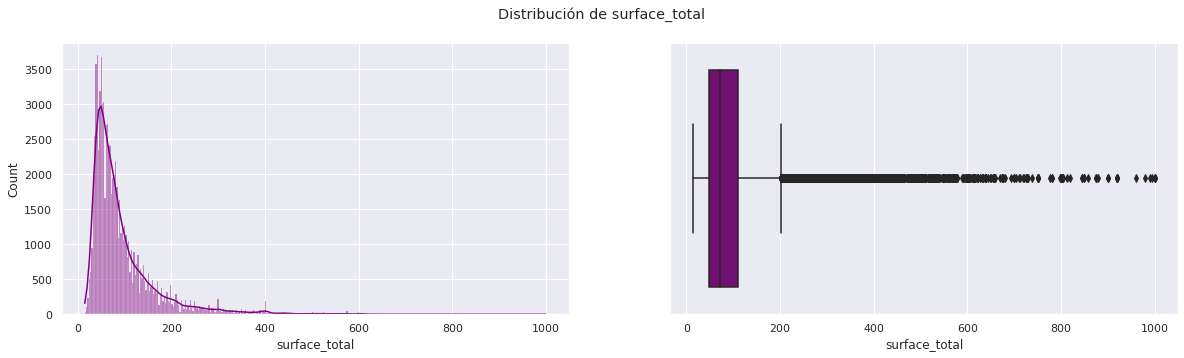

In [86]:
# Surface total
# print(df.surface_total.describe())
fig, axes = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Distribución de surface_total')

sns.histplot(ax=axes[0], x=df.surface_total, color="purple", kde=True)
sns.boxplot(ax=axes[1], x=df.surface_total, color="purple")

<AxesSubplot:xlabel='surface_covered'>

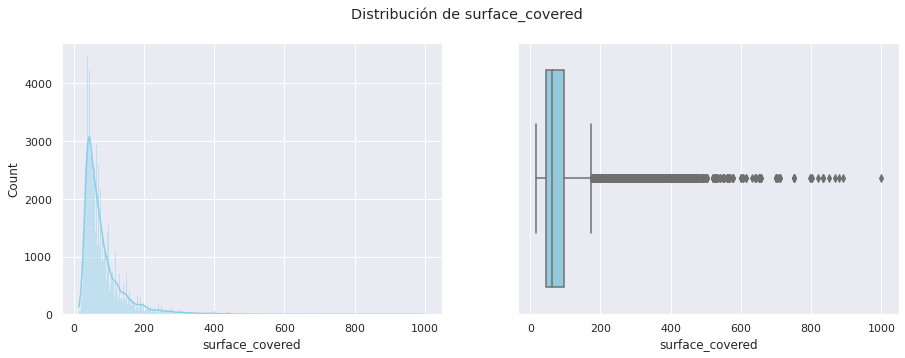

In [87]:
# Surface covered
# print(df.surface_covered.describe())
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de surface_covered')

sns.histplot(ax=axes[0], x=df.surface_covered, color="skyblue", kde=True)
sns.boxplot(ax=axes[1], x=df.surface_covered, color="skyblue")

<AxesSubplot:xlabel='price'>

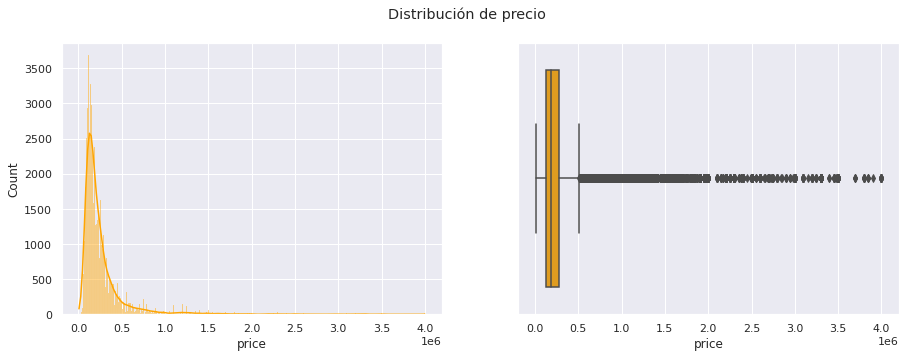

In [88]:
# Precio
# print(df.price.describe())
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de precio')

sns.histplot(ax=axes[0], x=df.price, color="orange", kde=True)
sns.boxplot(ax=axes[1], x=df.price, color="orange")

### <font color=blue>**Detección de valores faltantes**</font> 

Veo qué valores faltan en el dataset. En un análisis previo (no se muestra) realicé la imputación previo al filtrado de outliers, sin embargo observo que obtengo mejores resultados sin este paso previo (debido a que la dispersión de los datos es muy alta y la mediana con la que realicé la imputación es mayor a la que tendrían los datos sin valores de outliers tan grandes). Solamente muestro los valores faltantes antes de la eliminación de outliers y luego de su eliminación para asegurarme de que no tener datos faltantes previo a la realización de los modelos predictivos.

In [123]:
# Veo cuáles son los datos faltantes antes de remover outliers
datos_faltantes = df.isna().sum().sort_values(ascending=False)
print(datos_faltantes)

# Convierto los datos faltantes a porcentaje
nulos = [var for var in df.columns if df[var].isnull().sum() > 0]
nulos_df = df[nulos].isnull().mean()
print('\n Los datos faltantes (en porcentaje) por columnas son: \n', nulos_df)

bathrooms            837
Villa del Parque       0
Congreso               0
Caballito              0
Catalinas              0
                    ... 
Parque Chacabuco       0
Parque Centenario      0
Parque Avellaneda      0
Palermo                0
rooms                  0
Length: 66, dtype: int64

 Los datos faltantes (en porcentaje) por columnas son: 
 bathrooms    0.010234
dtype: float64


In [90]:
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,81786.000000,81786.000000,80949.000000,81786.000000,81786.000000,8.178600e+04,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000,81786.000000
mean,3.007972,2.001003,1.554040,95.299978,82.389932,2.632679e+05,0.026961,0.855122,0.117917,0.005001,0.001895,0.083364,0.029626,0.008388,0.038002,0.073521,0.003362,0.009231,0.070428,0.000061,0.005881,0.007935,0.006236,0.015981,0.007434,0.004671,0.026313,0.010100,0.008437,0.007923,0.006786,0.009060,0.006823,0.022473,0.009060,0.150857,0.002519,0.015553,0.008645,0.003093,0.005319,0.011946,0.002482,0.021079,0.067554,0.009500,0.011579,0.011726,0.008534,0.011652,0.001920,0.001663,0.002592,0.073081,0.015589,0.004059,0.005588,0.006199,0.003118,0.008204,0.001602,0.000416,0.003766,0.000783,0.036216,0.015174
std,1.308775,1.051268,0.852858,77.256320,62.548571,2.981711e+05,0.161969,0.351980,0.322512,0.070540,0.043493,0.276433,0.169555,0.091200,0.191201,0.260992,0.057889,0.095636,0.255868,0.007819,0.076464,0.088727,0.078721,0.125402,0.085900,0.068183,0.160064,0.099988,0.091464,0.088659,0.082098,0.094754,0.082318,0.148218,0.094754,0.357912,0.050124,0.123738,0.092574,0.055533,0.072736,0.108643,0.049759,0.143650,0.250981,0.097006,0.106982,0.107649,0.091988,0.107316,0.043772,0.040745,0.050847,0.260271,0.123881,0.063584,0.074543,0.078490,0.055751,0.090206,0.039990,0.020385,0.061252,0.027963,0.186829,0.122244
min,1.000000,0.000000,1.000000,15.000000,15.000000,6.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.250000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

### <font color=blue>**Detección y eliminación de outliers**</font> 

Voy a filtrar en primer lugar aquellas propiedades con superficies cubiertas muy altas, ya que se trata del atributo con la mayor desviación estándar.

### <font color=blue>Remuevo outliers con el método del rango intercuartílico (IQR)</font> 

Empleo el método IQR para eliminar outlieres porque del análisis anterior se observa que la mayor parte de los atributos presentan distribución con asimetría positiva muy marcada. Aplicar el método de las 3 sigmas en estas distribuciones que no siguen un patrón gaussiano típico no sería lo ideal.

Shape del dataset original: (81786, 66)
Shape del dataset luego de eliminar outliers: (75550, 66)


<AxesSubplot:xlabel='surface_total'>

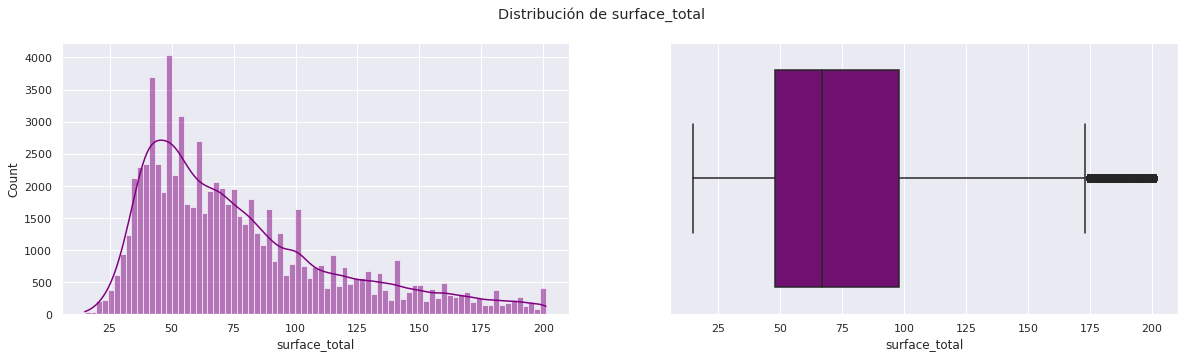

In [124]:
# Defino una función para filtar valores que queden dentro del IQR
def IQR(dato):
    q25,q75 = np.nanpercentile(dato.values, [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
#     print(q25, q75, minimo, maximo)
    filtro = (dato > minimo) & (dato < maximo)
    return filtro

print('Shape del dataset original:', df.shape)

df = df[IQR(df.surface_total) == True]

print('Shape del dataset luego de eliminar outliers:', df.shape)

# Surface total
# print(df.surface_total.describe())
fig, axes = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Distribución de surface_total')

sns.histplot(ax=axes[0], x=df.surface_total, color="purple", kde=True)
sns.boxplot(ax=axes[1], x=df.surface_total, color="purple")

In [92]:
# Evalúo la distribución del resto de los atributos
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,75550.000000,75550.000000,74783.000000,75550.000000,75550.000000,7.555000e+04,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000,75550.000000
mean,2.821363,1.862938,1.439324,77.951463,69.285983,2.134496e+05,0.012032,0.877392,0.110576,0.005334,0.001919,0.087796,0.030602,0.008061,0.037922,0.071449,0.003349,0.009239,0.072204,0.000066,0.006168,0.008312,0.006420,0.016188,0.007558,0.004844,0.026075,0.009861,0.007981,0.008021,0.006367,0.009424,0.006962,0.022462,0.009490,0.149490,0.002290,0.016744,0.008312,0.003177,0.004990,0.011979,0.002052,0.017181,0.062065,0.009080,0.011807,0.011979,0.008961,0.011780,0.002078,0.001549,0.002290,0.077247,0.014480,0.004077,0.005136,0.006274,0.003150,0.008127,0.001588,0.000384,0.003786,0.000582,0.037962,0.015328
std,1.078840,0.907404,0.702738,39.586217,35.249151,1.538687e+05,0.109028,0.327988,0.313608,0.072841,0.043768,0.283000,0.172239,0.089420,0.191009,0.257576,0.057772,0.095675,0.258827,0.008135,0.078295,0.090793,0.079865,0.126199,0.086608,0.069434,0.159361,0.098812,0.088982,0.089202,0.079537,0.096621,0.083150,0.148181,0.096956,0.356574,0.047798,0.128311,0.090793,0.056273,0.070464,0.108791,0.045249,0.129945,0.241275,0.094856,0.108016,0.108791,0.094238,0.107897,0.045539,0.039323,0.047798,0.266984,0.119461,0.063720,0.071480,0.078960,0.056039,0.089784,0.039823,0.019589,0.061411,0.024126,0.191105,0.122853
min,1.000000,0.000000,1.000000,15.000000,15.000000,6.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,48.000000,43.000000,1.200000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Evalúo como queda la siguiente variable que tenía alto std y alta diferencia en máximo y mínimo, surface_covered

<AxesSubplot:xlabel='surface_covered'>

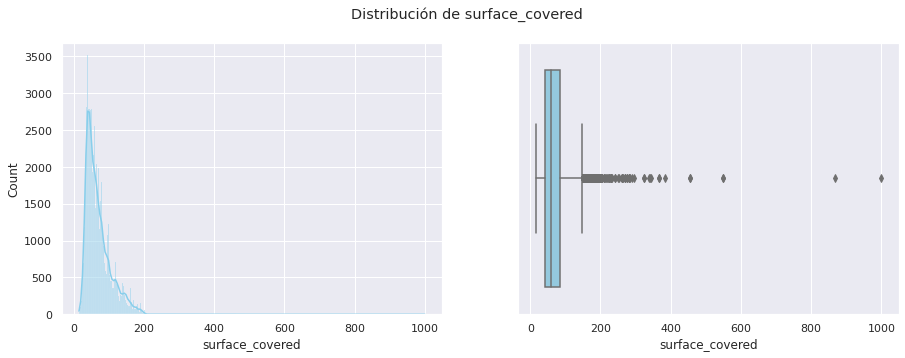

In [93]:
# Surface covered
# print(df.surface_covered.describe())
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de surface_covered')

sns.histplot(ax=axes[0], x=df.surface_covered, color="skyblue", kde=True)
sns.boxplot(ax=axes[1], x=df.surface_covered, color="skyblue")

Shape del dataset pre-filtrado: (75550, 66)
Shape del dataset luego de eliminar outliers: (72243, 66)
count    72243.000000
mean        64.779453
std         28.209664
min         15.000000
25%         43.000000
50%         58.000000
75%         80.000000
max        147.000000
Name: surface_covered, dtype: float64


<AxesSubplot:xlabel='surface_covered'>

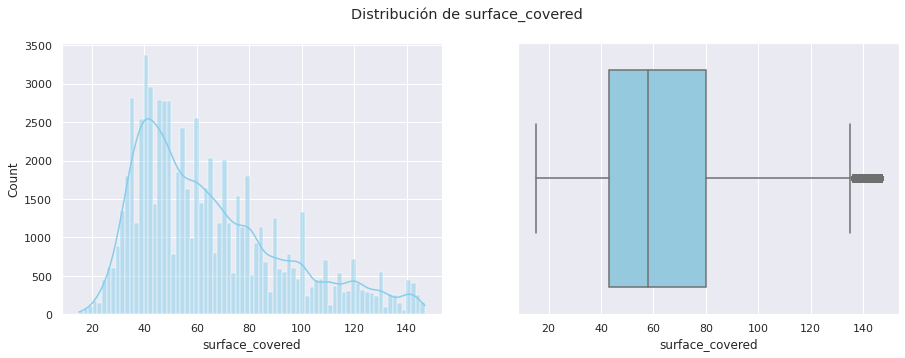

In [125]:
print('Shape del dataset pre-filtrado:', df.shape)

df = df[IQR(df.surface_covered) == True]

print('Shape del dataset luego de eliminar outliers:', df.shape)

# Surface covered
print(df.surface_covered.describe())
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de surface_covered')

sns.histplot(ax=axes[0], x=df.surface_covered, color="skyblue", kde=True)
sns.boxplot(ax=axes[1], x=df.surface_covered, color="skyblue")

La distribución tiene coherencia. Sigo evaluando el resto de las variables.

In [126]:
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,72243.000000,72243.000000,71497.000000,72243.00000,72243.000000,7.224300e+04,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000,72243.000000
mean,2.740155,1.797544,1.384729,73.59322,64.779453,1.985067e+05,0.008513,0.884086,0.107401,0.005551,0.001966,0.089656,0.031463,0.008070,0.037360,0.069308,0.003488,0.009330,0.072312,0.000069,0.006160,0.008153,0.006547,0.016749,0.007821,0.005025,0.025926,0.010132,0.007779,0.008015,0.006354,0.009177,0.007212,0.022798,0.009080,0.150506,0.002339,0.016458,0.008568,0.003101,0.005052,0.011697,0.002035,0.014410,0.058954,0.008388,0.012029,0.012347,0.009164,0.012057,0.001993,0.001592,0.002284,0.078665,0.014520,0.004056,0.005163,0.006381,0.003225,0.008347,0.001620,0.000388,0.003945,0.000540,0.039049,0.015628
std,1.004338,0.849104,0.639754,34.48132,28.209664,1.248151e+05,0.091873,0.320124,0.309625,0.074297,0.044292,0.285690,0.174567,0.089471,0.189644,0.253979,0.058959,0.096139,0.259005,0.008319,0.078243,0.089926,0.080651,0.128331,0.088090,0.070707,0.158917,0.100150,0.087857,0.089166,0.079456,0.095359,0.084616,0.149260,0.094858,0.357569,0.048310,0.127231,0.092168,0.055597,0.070901,0.107517,0.045063,0.119173,0.235540,0.091204,0.109015,0.110431,0.095287,0.109139,0.044602,0.039866,0.047736,0.269217,0.119624,0.063556,0.071670,0.079628,0.056700,0.090980,0.040211,0.019683,0.062686,0.023228,0.193712,0.124031
min,1.000000,0.000000,1.000000,15.00000,15.000000,7.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,47.00000,43.000000,1.190000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

Ordeno las propiedades por el atributo "rooms" de mayor a menos, para observar si existen variables que deban ser quitar manualmente. La eliminación de de rooms, bedrooms y bathrooms por intervalo intercuartílico trae la eliminación de registros con propiedades de 5 rooms o 4 bedrooms por ejemplo, lo cual no sería coherente con las propiedades existentes en Capital Fedreal. Voy a realizar la eliminación con el método de las 3 sigmas para quedarme con propiedades con mayor número de rooms pero que estén con suficiente respresentación en el modelo.

In [127]:
# Defino una función para eliminación de outliers por 3 sigmas

def outliers_3sigmas(df):
    valor_medio = df.mean()
    std = df.std()
    minimo_sigma = valor_medio - 3*std
    maximo_sigma = valor_medio + 3*std
    no_outliers = (df > minimo_sigma) & (df < maximo_sigma)    
    return no_outliers

df = df[outliers_3sigmas(df.rooms) == True] 

df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,71862.000000,71862.000000,71120.000000,71862.000000,71862.000000,7.186200e+04,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.00000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000,71862.000000
mean,2.720033,1.783710,1.381538,73.251746,64.480727,1.980935e+05,0.008196,0.885851,0.105953,0.005413,0.001976,0.089783,0.031185,0.008001,0.037335,0.069453,0.003507,0.009310,0.072570,0.000070,0.006053,0.008168,0.006582,0.016838,0.007848,0.004982,0.025883,0.010089,0.007779,0.008057,0.006304,0.009073,0.007208,0.022835,0.009045,0.150928,0.002352,0.016546,0.008516,0.003117,0.005065,0.011731,0.001962,0.014486,0.058765,0.008252,0.012051,0.012343,0.009045,0.012079,0.00192,0.001586,0.002296,0.078512,0.014542,0.004008,0.005177,0.006401,0.003228,0.008349,0.001628,0.000390,0.003966,0.000543,0.039200,0.015669
std,0.964247,0.822067,0.637641,34.191562,27.942981,1.247205e+05,0.090162,0.317995,0.307780,0.073375,0.044409,0.285873,0.173818,0.089093,0.189584,0.254224,0.059114,0.096036,0.259431,0.008341,0.077567,0.090010,0.080863,0.128664,0.088243,0.070406,0.158787,0.099936,0.087854,0.089400,0.079146,0.094820,0.084596,0.149380,0.094675,0.357981,0.048438,0.127562,0.091891,0.055744,0.070991,0.107672,0.044252,0.119484,0.235187,0.090465,0.109114,0.110412,0.094675,0.109238,0.04378,0.039798,0.047863,0.268977,0.119710,0.063180,0.071763,0.079751,0.056728,0.090993,0.040317,0.019735,0.062851,0.023290,0.194072,0.124192
min,1.000000,0.000000,1.000000,15.000000,15.000000,7.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,47.000000,43.000000,1.190000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

Realizo una inspección de bedrooms y bathrooms para considerar la eliminación de outliers.

<AxesSubplot:xlabel='bathrooms'>

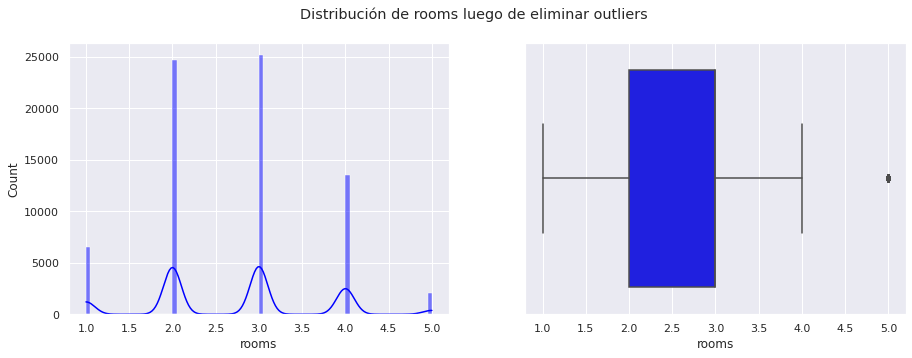

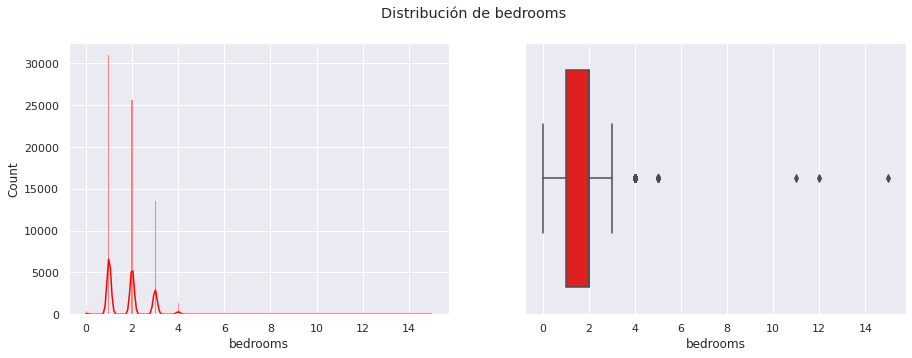

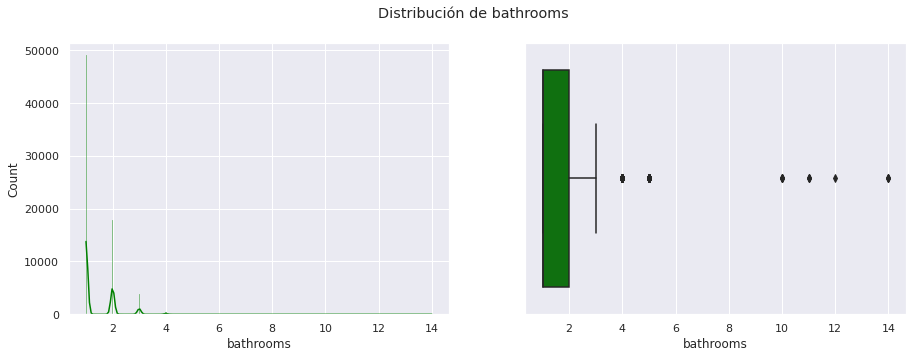

In [98]:
# Rooms
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de rooms luego de eliminar outliers')

sns.histplot(ax=axes[0], x=df.rooms, color="blue", kde=True)
sns.boxplot(ax=axes[1], x=df.rooms, color="blue")

# Bedrooms
df.bedrooms.describe()
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de bedrooms')

sns.histplot(ax=axes[0], x=df.bedrooms, color="red", kde=True)
sns.boxplot(ax=axes[1], x=df.bedrooms, color="red")

# Bathrooms
df.bathrooms.describe()
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de bathrooms')

sns.histplot(ax=axes[0], x=df.bathrooms, color="green", kde=True)
sns.boxplot(ax=axes[1], x=df.bathrooms, color="green")

In [131]:
# Elimino outliers en bedrooms
df = df[outliers_3sigmas(df.bedrooms) == True] 
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,71851.000000,71851.000000,71109.000000,71851.000000,71851.000000,7.185100e+04,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.00000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000,71851.000000
mean,2.719879,1.782898,1.381386,73.245522,64.473925,1.980868e+05,0.008198,0.885847,0.105955,0.005414,0.001976,0.089797,0.031190,0.008003,0.037313,0.069421,0.003493,0.009311,0.072567,0.000070,0.006054,0.008170,0.006583,0.016840,0.00785,0.004955,0.025887,0.010090,0.007780,0.008058,0.006305,0.009074,0.007209,0.022839,0.009046,0.150951,0.002352,0.016548,0.008518,0.003118,0.005066,0.011733,0.001962,0.014488,0.058774,0.008253,0.012053,0.012345,0.009046,0.012067,0.001921,0.001587,0.002296,0.078524,0.014544,0.004008,0.005163,0.006402,0.003229,0.008351,0.001628,0.000390,0.003967,0.000543,0.039206,0.015671
std,0.964138,0.818339,0.637435,34.186908,27.935472,1.247217e+05,0.090169,0.317999,0.307783,0.073381,0.044412,0.285893,0.173831,0.089100,0.189530,0.254171,0.059002,0.096044,0.259426,0.008342,0.077573,0.090017,0.080869,0.128674,0.08825,0.070216,0.158799,0.099943,0.087861,0.089406,0.079152,0.094827,0.084602,0.149391,0.094683,0.358004,0.048442,0.127572,0.091898,0.055748,0.070996,0.107681,0.044256,0.119493,0.235204,0.090472,0.109122,0.110421,0.094683,0.109184,0.043783,0.039801,0.047866,0.268996,0.119719,0.063185,0.071672,0.079757,0.056732,0.091000,0.040320,0.019737,0.062856,0.023292,0.194086,0.124201
min,1.000000,0.000000,1.000000,15.000000,15.000000,7.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,47.000000,43.000000,1.190000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [132]:
print('Shape del dataset pre-filtrado:', df.shape)

Shape del dataset pre-filtrado: (71851, 66)


In [133]:
df2 = df.sort_values(by=['bathrooms'],ascending=False)
df2.head(5)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
132709,2.0,1.0,14.0,45.0,45.0,159000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
136930,2.0,1.0,14.0,45.0,45.0,159000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35960,2.0,1.0,14.0,50.0,50.0,225000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53274,1.0,1.0,12.0,38.0,34.0,140000.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73948,2.0,1.0,11.0,44.0,36.0,149000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Considero eliminar outliers en bathrooms porque tengo demasiados baños para tan pocos metros cuadrados y rooms/bedrooms. Empleo el método de las 3 sigmas.

In [134]:
# Elimino outliers en bathrooms con la misma metodología
df = df[outliers_3sigmas(df.bathrooms) == True] 
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,7.055300e+04,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000,70553.000000
mean,2.711678,1.774666,1.359120,72.820787,64.089833,1.961805e+05,0.008022,0.885760,0.106218,0.005499,0.002013,0.090797,0.031239,0.007824,0.037234,0.069054,0.003515,0.009426,0.071577,0.000071,0.006109,0.008277,0.006591,0.016739,0.007852,0.005032,0.025895,0.010106,0.007385,0.007470,0.006180,0.009071,0.007328,0.022834,0.009199,0.151007,0.002367,0.016768,0.008561,0.003090,0.005074,0.011523,0.001984,0.014287,0.059005,0.008320,0.012204,0.012402,0.009014,0.012048,0.001956,0.001517,0.002296,0.078919,0.014641,0.004068,0.005131,0.006052,0.003260,0.008419,0.001644,0.000383,0.003983,0.000553,0.039375,0.015832
std,0.958524,0.810931,0.580272,33.783955,27.547716,1.210875e+05,0.089208,0.318105,0.308119,0.073954,0.044818,0.287322,0.173964,0.088107,0.189337,0.253549,0.059184,0.096627,0.257789,0.008418,0.077921,0.090604,0.080916,0.128293,0.088265,0.070756,0.158824,0.100019,0.085616,0.086104,0.078369,0.094811,0.085289,0.149375,0.095469,0.358058,0.048595,0.128400,0.092129,0.055501,0.071053,0.106727,0.044502,0.118673,0.235636,0.090834,0.109795,0.110672,0.094516,0.109100,0.044183,0.038914,0.047863,0.269615,0.120114,0.063650,0.071447,0.077561,0.057003,0.091370,0.040515,0.019559,0.062984,0.023505,0.194486,0.124826
min,1.000000,0.000000,1.000000,15.000000,15.000000,7.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,47.000000,42.000000,1.190000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

<AxesSubplot:xlabel='price'>

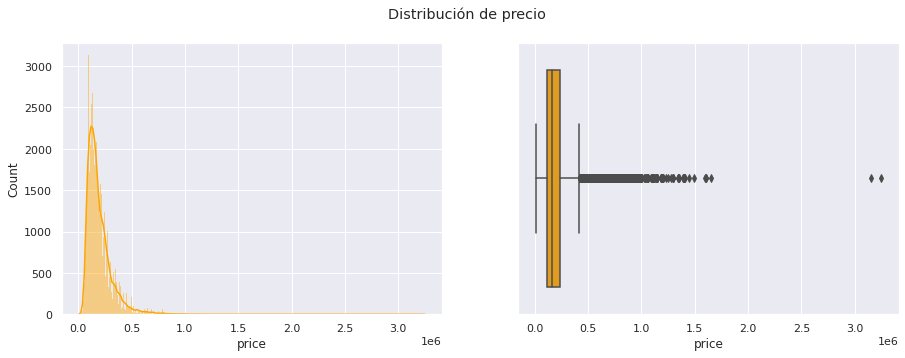

In [135]:
# Evalúo la variable precio
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de precio')

sns.histplot(ax=axes[0], x=df.price, color="orange", kde=True)
sns.boxplot(ax=axes[1], x=df.price, color="orange")

In [136]:
valor_medio = df.price.mean()
std = df.price.std()
minimo_sigma = valor_medio - 3*std
maximo_sigma = valor_medio + 3*std
print(valor_medio,std,minimo_sigma,maximo_sigma)

196180.51335875157 121087.46128329633 -167081.8704911374 559442.8972086406


In [137]:
print(df.shape)
# Cantidad de propiedades cuyo valor es menor o igual a 50.000 USD
len(df[df['price'] <= 50000])

(70553, 66)


234

Si realizo la eliminación de outlieres por el método de las 3 sigmas me quedo con valores de precio de venta muy bajos para la Capital Federal, debido a que el valor mínimo queda en un número negativo. Considerando páginas de precios de venta de inmuebles en Capital Federal (Zonaprop) no se encuentran propiedades de menos de 50.000 USD para la venta. Es probable que dichos valores correspondan a alquileres o a cocheras más que a Casas, departamentos o PH.   
La cantidad de propiedades con valores menores a dicho precio son 234 (0.33% de los datos), por lo cual los elimino de manera manual.

In [138]:
df = df[df['price'] > 50000]  
print(df.shape)
df = df.sort_values(by=['price'],ascending=True)

(70319, 66)


In [139]:
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,7.031900e+04,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.00000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000,70319.000000
mean,2.714871,1.776533,1.360272,72.946714,64.192025,1.966894e+05,0.008049,0.885678,0.106273,0.005418,0.002019,0.091028,0.031172,0.007836,0.03733,0.069270,0.003470,0.009386,0.071673,0.000071,0.006101,0.008291,0.006599,0.016781,0.007836,0.004750,0.025797,0.010097,0.007409,0.007324,0.006044,0.008988,0.007352,0.022910,0.009172,0.151481,0.002318,0.016809,0.008433,0.003086,0.005020,0.011505,0.001934,0.014335,0.059187,0.008319,0.012187,0.012358,0.008902,0.012088,0.001962,0.001522,0.002275,0.079154,0.014676,0.004081,0.004750,0.006072,0.003257,0.008405,0.001650,0.000384,0.003982,0.000356,0.039506,0.015885
std,0.957227,0.811095,0.580832,33.756497,27.523393,1.209655e+05,0.089355,0.318204,0.308189,0.073409,0.044892,0.287651,0.173784,0.088173,0.18957,0.253915,0.058804,0.096425,0.257948,0.008432,0.077869,0.090676,0.080963,0.128450,0.088173,0.068755,0.158530,0.099975,0.085757,0.085266,0.077508,0.094377,0.085430,0.149617,0.095334,0.358520,0.048090,0.128557,0.091444,0.055466,0.070674,0.106642,0.043936,0.118867,0.235977,0.090830,0.109722,0.110478,0.093932,0.109279,0.044257,0.038979,0.047647,0.269980,0.120253,0.063756,0.068755,0.077689,0.056974,0.091291,0.040582,0.019591,0.062977,0.018852,0.194796,0.125031
min,1.000000,0.000000,1.000000,15.000000,15.000000,5.050000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,47.000000,43.000000,1.190000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

<AxesSubplot:xlabel='price'>

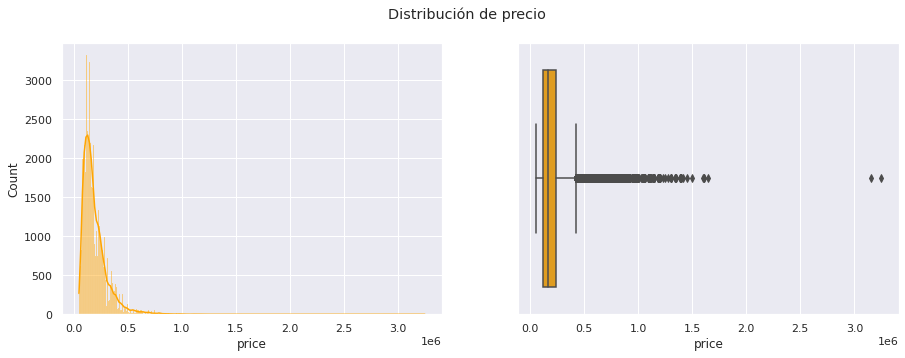

In [140]:
# Evalúo la variable precio
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de precio')

sns.histplot(ax=axes[0], x=df.price, color="orange", kde=True)
sns.boxplot(ax=axes[1], x=df.price, color="orange")

Elimino outliers por el método de las 3 sigmas, debido a que hay valores en el extremo derecho de la curva que están poco representados para la realización de los modelos predictivos.

In [148]:
valor_medio = df.price.mean()
std = df.price.std()
minimo_sigma = valor_medio - 3*std
maximo_sigma = valor_medio + 3*std
print(valor_medio,std,minimo_sigma,maximo_sigma)

196689.38555724625 120965.4915794785 -166207.08918118928 559585.8602956817


In [141]:
# Elimino outliers en price 
df = df[outliers_3sigmas(df.price) == True] 
df.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
count,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.00000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.00000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000,69017.000000
mean,2.701378,1.765203,1.339380,71.839243,63.168756,186695.952084,0.008186,0.883594,0.10822,0.005520,0.002057,0.092745,0.031760,0.007984,0.037455,0.068273,0.003535,0.009563,0.072779,0.000072,0.006216,0.008447,0.006680,0.01701,0.007984,0.004839,0.026269,0.010287,0.006882,0.007462,0.006158,0.009157,0.007491,0.022806,0.009346,0.148746,0.002362,0.017126,0.008578,0.003144,0.005100,0.011722,0.001971,0.008288,0.058304,0.008346,0.012417,0.012591,0.009070,0.012316,0.002000,0.001550,0.002318,0.080632,0.014909,0.004158,0.004825,0.006158,0.003318,0.008563,0.001681,0.000391,0.004057,0.000362,0.040034,0.016184
std,0.955842,0.809434,0.559926,32.916915,26.622934,93901.862622,0.090108,0.320714,0.31066,0.074094,0.045313,0.290077,0.175363,0.088994,0.189874,0.252216,0.059354,0.097322,0.259776,0.008511,0.078596,0.091520,0.081455,0.12931,0.088994,0.069398,0.159935,0.100904,0.082675,0.086060,0.078231,0.095255,0.086226,0.149286,0.096220,0.355840,0.048541,0.129743,0.092218,0.055985,0.071234,0.107631,0.044347,0.090660,0.234320,0.090974,0.110739,0.111502,0.094806,0.110292,0.044671,0.039344,0.048093,0.272272,0.121191,0.064352,0.069294,0.078231,0.057507,0.092141,0.040963,0.019775,0.063565,0.019029,0.196039,0.126185
min,1.000000,0.000000,1.000000,15.000000,15.000000,50500.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,47.000000,42.000000,118000.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [142]:
df.shape

(69017, 66)

<AxesSubplot:xlabel='price'>

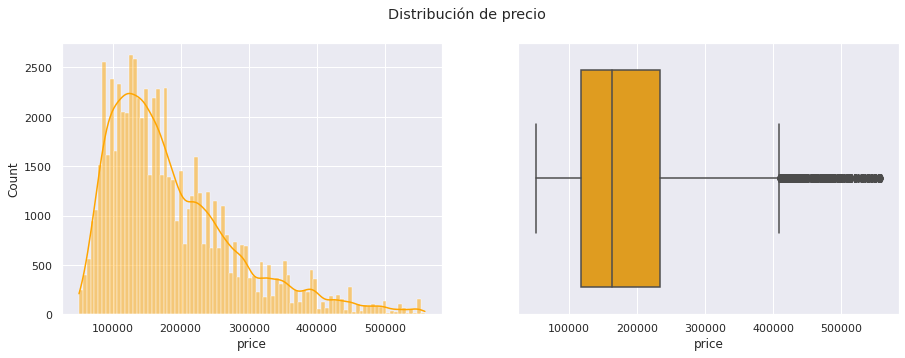

In [143]:
# Evalúo la variable precio
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribución de precio')

sns.histplot(ax=axes[0], x=df.price, color="orange", kde=True)
sns.boxplot(ax=axes[1], x=df.price, color="orange")

In [144]:
#Realizo una copia y guardado del dataset con el preprocesamiento realidado 

df2 = df.copy()
df2.to_csv (r'/home/lulu/Documents/Acámica/Segundo proyecto/df_parteb.csv', index = False, header=True)

In [145]:
# Importo el dataset para implementar modelo del proyecto 1
df2 = pd.read_csv('df_parteb.csv')
df2.head()
df2.shape

(69017, 66)

### <font color=blue>**Mejor modelo elegido en el proyecto 1 implementado con el dataset transformado**</font> 

El modelo que mejor desempeño tuvo en el Proyecto 1 fue el **Árbol de decisión con una profundidad de 16**. Voy a aplicar dicho modelo sobre el dataset transformado para evaluar el impacto del preprocesamiento sobre el resultado final del mismo modelo.

In [146]:
# Defino X e y
X = df2.drop('price', axis=1)
y = df2.price

# Realizo un train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo con el valor de profundidad
tree_regressor = DecisionTreeRegressor(max_depth=16, random_state=42)
    
# Entrenar el modelo
tree_regressor.fit(X_train,y_train)
    
# Predecir y evaluar sobre el set de entrenamiento y testeo
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)
    
# Evalúo el modelo con RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 33197.92257523444
Raíz del error cuadrático medio en Test: 41295.2878457197


**Conclusiones**

Podemos observar que el mismo modelo presenta grandes mejoras respecto al Proyecto 1 (RMSE en Test: 107205.71). Esto demuestra que el preprocesamiento de datos es un paso más que esencial a la hora de trabajar con un dataset. Elegir con criterio como tratar outliers y valores faltantes, al mismo tiempo que considerar realizar encoders para variables categóricas que puedan aportar información mejora el rendimiento de los modelos y la capacidad predictiva de los mismos.

## <font color=orange>**Parte B: Modelos avanzados**</font> 

  1- Elige dos de los modelos avanzados vistos. Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.  
   2- Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.  
   3- Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.  

In [147]:
# Importo el dataset para implementar modelos avanzados
df2 = pd.read_csv('df_parteb.csv')
df2.head()
df2.shape

(69017, 66)

Realizo una **matriz de correlación** entre los atributos (los que no provienen de encoders para evaluar si existen atributos correlacionados.

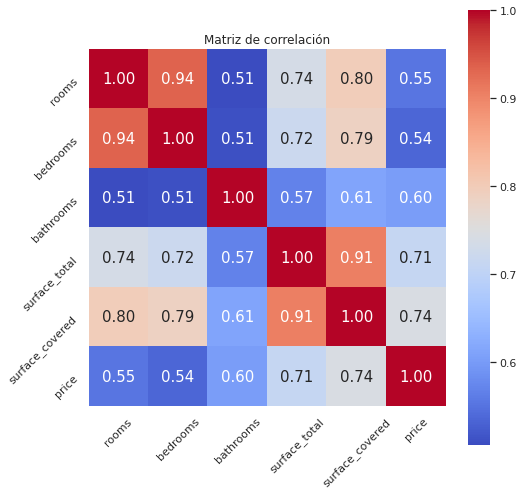

In [148]:
corr = df2[(df2.columns[:6])].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Matriz de correlación', fontsize=12)
plt.show()

Encuentro que rooms y bedrooms se encuentran altamente corerlacionadsa (0.94) y surface_total y surface_covered también (0.91). Antes de remover alguna de ambas del dataset voy a estudiar las matrices de correlación según el tipo de propiedad (Casa, Departamento y PH) para ver si encuentro diferencias entre ellas.

In [149]:
# Selecciono según tipo de propiedad
df2_casa = df2[df2.Casa == 1]
df2_PH = df2[df2.Departamento == 1]
df2_dpto = df2[df2.PH == 1]

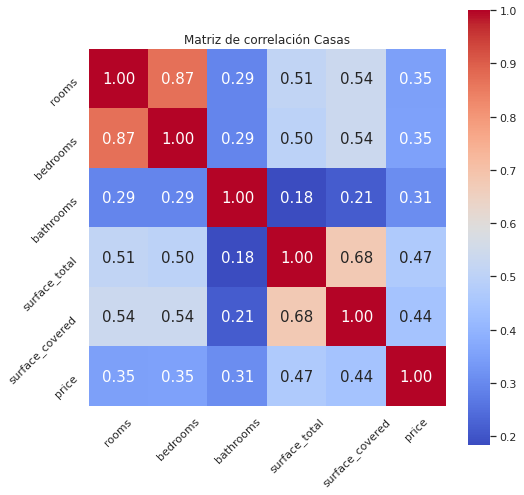

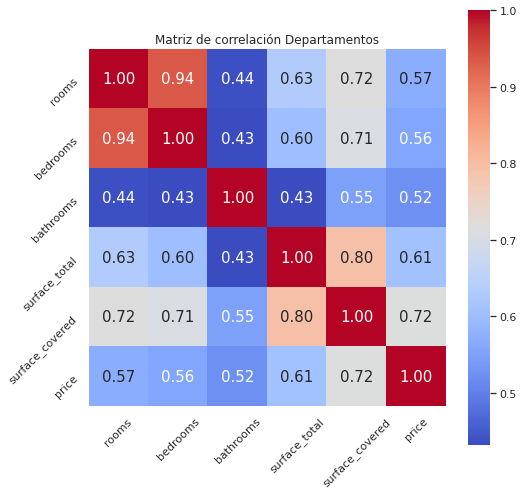

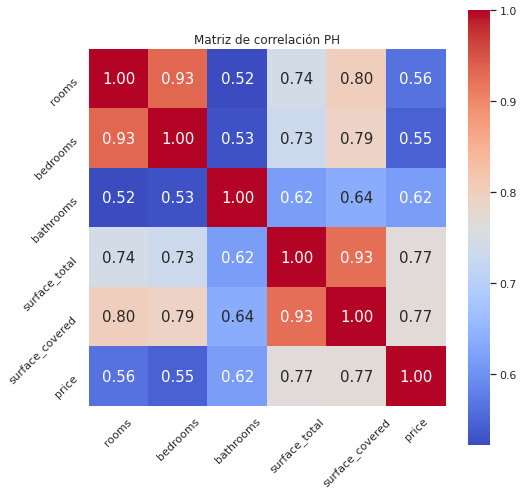

In [150]:
# Matriz de correlación para Casa
corr = df2_casa[(df2_casa.columns[:6])].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Matriz de correlación Casas', fontsize=12)
plt.show()

# Matriz de correlación para Departamento
corr = df2_dpto[(df2_dpto.columns[:6])].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Matriz de correlación Departamentos', fontsize=12)
plt.show()

# Matriz de correlación para PH
corr = df2_PH[(df2_PH.columns[:6])].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Matriz de correlación PH', fontsize=12)
plt.show()

Debido a que rooms y bedrooms poseen alta correlación (0.94 en el conjunto global, con un rango de 0.87-0.94 según tipo de propiedad), elimino el atributo bedrooms.   

En cambio, surface_total y surface_covered se encuentran en alta correlación en el global (0.91) pero hay marcadas diferencias en el tipo de propiedad: correlación de 0.68 para Casas, 0.80 para Departamentos y 0.93 para PH. Por lo tanto, decido quedarme con ambos atributos para la confección de los modelos avanzados.

In [151]:
df2 = df2.drop('bedrooms', axis=1)
df2.head()

,rooms,bathrooms,surface_total,surface_covered,price,Casa,Departamento,PH,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,Catalinas,Centro / Microcentro,Chacarita,Coghlan,Colegiales,Congreso,Constitución,Flores,Floresta,Las Cañitas,Liniers,Mataderos,Monserrat,Monte Castro,Nuñez,Once,Palermo,Parque Avellaneda,Parque Centenario,Parque Chacabuco,Parque Chas,Parque Patricios,Paternal,Pompeya,Puerto Madero,Recoleta,Retiro,Saavedra,San Cristobal,San Nicolás,San Telmo,Tribunales,Velez Sarsfield,Versalles,Villa Crespo,Villa Devoto,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Riachuelo,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
0,1.0,1.0,19.0,19.0,50500.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,31.0,23.0,51000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,38.0,38.0,51000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,25.0,25.0,51000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,42.0,21.0,51000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Evalúo la multicolinealidad mediante **Variance Inflation Factor(VIF)**:  

– VIF=1; No multicollinearity    
– VIF=<5; Low multicollinearity or moderately correlated    
– VIF=>5; High multicollinearity or highly correlated    

In [152]:
# Defino xx para calcular los VIF
xx = df2.drop(['price'], axis=1)

# Defino y
y = df2.price

# Elijo los atributos para calcular VIF
names = list(df2[df2.columns[:4]]) 

# Realizo un DataFrame en pandas para el análisis
df_vif = pd.DataFrame(xx, columns=names)

for index in range(0, len(names)):
            y = df_vif.loc[:, df_vif.columns == names[index]]
            x = df_vif.loc[:, df_vif.columns != names[index]]
            model = sm.OLS(y, x)                       #OLS = ordinary least squares method
            results = model.fit()
            rsq = results.rsquared
            vif = round(1 / (1 - rsq), 2)
            print("R Square value of {} column is {} keeping all other columns as independent features".format(
              names[index], (round(rsq, 2))
                    )
            )
            print("Variance Inflation Factor of {} column is {} n".format(
                 names[index], vif)
          )

R Square value of rooms column is 0.95 keeping all other columns as independent features
Variance Inflation Factor of rooms column is 19.33 n
R Square value of bathrooms column is 0.89 keeping all other columns as independent features
Variance Inflation Factor of bathrooms column is 9.44 n
R Square value of surface_total column is 0.97 keeping all other columns as independent features
Variance Inflation Factor of surface_total column is 32.72 n
R Square value of surface_covered column is 0.98 keeping all other columns as independent features
Variance Inflation Factor of surface_covered column is 50.0 n


### <font color=orange>**Modelo avanzado 1: Regresión lineal con transformación polinómica**</font> 

En primer lugar realizo una **regresión lineal con los argumentos por default**, para considerar el punto de partida antes de optimizar los hiperparámetros. Aplico el escalado de datos antes de realizar la regresión lineal.

Aplico la regresión lineal sobre los datos escalados.

In [262]:
# Defino X e y
X = df2.drop('price', axis=1)
y = df2.price

# Realizo un train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalo los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Realizo la regresión lineal
reg = LinearRegression()

# Validación cruzada
reg_cv = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2')
print(reg_cv)

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Evalúo el modelo con RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

[0.75960557 0.74937575 0.75751674 0.76078177 0.75147614]
Raíz del error cuadrático medio en Train: 46396.10847932577
Raíz del error cuadrático medio en Test: 45764.190074751656


En este caso, evaluada sobre el mismo dataset, la regresión lineal tiene un peor desempeño que los Árboles de decisión (max_depth = 16) elegido como mejor modelo en el Proyecto 1.  

RMSE Árbol de decisión (Test): 41295.29  
RMSE Regresión lineal (Test): 45764.19

Comienzo la aplicación de la Regresión lineal con atributos polinómicos y regularización.
**Comienzo aplicando atributos polinómicos (polynomial features)**

In [157]:
# separo los atributos a los que les voy a realizar polynomial features
z = df2[['rooms', 'bathrooms', 'surface_total', 'surface_covered']]
z.head()

,rooms,bathrooms,surface_total,surface_covered
0,1.0,1.0,19.0,19.0
1,1.0,1.0,31.0,23.0
2,2.0,1.0,38.0,38.0
3,1.0,1.0,25.0,25.0
4,1.0,1.0,42.0,21.0


In [158]:
# Convierto a atributos polinómicos y estandarizo en pipeline

steps = [
    ('poly', PolynomialFeatures(2)),  # Polynomial Features degree=2
    ('scalar', StandardScaler()),
]

pipe1 = Pipeline(steps)

z = pipe1.fit_transform(z)

z_df2 = pd.DataFrame(z)

z_df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,-1.779991,-0.60612,-1.605242,-1.659061,-1.322809,-1.046233,-1.220646,-1.242181,-0.562069,-0.978495,-0.970143,-0.963929,-1.051504,-1.052973
1,0.0,-1.779991,-0.60612,-1.240685,-1.508814,-1.322809,-1.046233,-1.146752,-1.213283,-0.562069,-0.844604,-0.918218,-0.865626,-0.977063,-1.012194
2,0.0,-0.733785,-0.60612,-1.028027,-0.945386,-0.772484,-0.684098,-0.869652,-0.830375,-0.562069,-0.766502,-0.723503,-0.786492,-0.822471,-0.790097
3,0.0,-1.779991,-0.60612,-1.422964,-1.433690,-1.322809,-1.046233,-1.183699,-1.198833,-0.562069,-0.911549,-0.892256,-0.920676,-0.995673,-0.988892
4,0.0,-1.779991,-0.60612,-0.906508,-1.583937,-1.322809,-1.046233,-1.079016,-1.227732,-0.562069,-0.721872,-0.944180,-0.734063,-0.941323,-1.033554


In [159]:
# Dataframe sólo con las variables dummies para agregar a los datos previamente transformados
z2 = df2.drop(['price', 'rooms', 'bathrooms', 'surface_total', 'surface_covered'], axis=1)

z2.reset_index(drop=True, inplace=True)
z_df2.reset_index(drop=True, inplace=True)

z_concat = [z_df2, z2]

# Defino X e y
X = pd.concat(z_concat, axis=1)
y = df2.price

print(X.shape)

(69017, 75)


In [160]:
# Divido el dataset para train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Realizo un **pipeline con escalado de datos y regresión lineal con regularización de Ridge, con optimización del hiperparámetro alpha de la regularización por GridSearchCV**

En la regularización, la principal diferencia práctica entre Lasso y Ridge es que el primero consigue que algunos coeficientes sean exactamente cero (por lo que realiza selección de predictores) mientras que el segundo no llega a excluir ninguno. Esto supone una ventaja notable de lasso en escenarios donde no todos los predictores son importantes para el modelo y se desea que los menos influyentes queden excluidos.  
Por otro lado, cuando existen predictores altamente correlacionados (linealmente), Ridge reduce la influencia de todos ellos a la vez y de forma proporcional, mientras que Lasso tiende a seleccionar uno de ellos, dándole todo el peso y excluyendo al resto. En presencia de correlaciones, esta selección varía mucho con pequeñas perturbaciones (cambios en los datos de entrenamiento), por lo que, las soluciones de Lasso, son muy inestables si los predictores están altamente correlacionados.   

En el caso de mi dataset, en la que se determinó la **alta multicolinealidad de los predictores**, eligo una postura más consevadora y trabajar con una regresión de Ridge para el modelo de regresión lineal.

El hiperparámetro que voy a optimizar es **alpha** que es la fuerza de la regularización (a mayor alpha, mayor regularización). Pruebo coeficientes en el rango 0-5.

In [176]:
# Defino el modelo
ridge_reg = Ridge()

# Grilla para Grid Search
params_ridge = {'alpha': [0, 0.01, 0.1, 1, 3, 5] 
                }

# Grid Search CV
ridge_gs = GridSearchCV(ridge_reg, param_grid=params_ridge, n_jobs=-1, cv = 5)

# Entreno
ridge_gs.fit(X_train,y_train)

# Resultados
print("Mejores parametros: "+str(ridge_gs.best_params_))
print("Mejor Score: "+str(ridge_gs.best_score_)+'\n')

#Predecimos en los datos de test
y_test_pred_reg = ridge_gs.predict(X_test)
y_train_pred_reg = ridge_gs.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_reg))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_reg))

print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Mejores parametros: {'alpha': 1}
Mejor Score: 0.7563965975474899

Raíz del error cuadrático medio en Train: 46333.14252959335
Raíz del error cuadrático medio en Test: 45692.06377457398


El alpha obtenido de la optimización de hiperparámetros es 1.

**Resultados modelo avanzado 1: Regresión lineal con transformación polinómica**

La aplicación de atributos polinómicos junto con regularización muestra una leve mejora sober el modelo de Regresión lineal simple con parámetros por default, pero no produce mejoras con respecto al modelo empleado en la Parte A. 

RMSE Árbol de decisión del Proyecto 1 (Test): 107205.71   
RMSE Árbol de decisión del Proyecto 2 (Test): 41295.29  
RMSE Regresión lineal (Test): 45764.19  
RMSE Regresión lineal con atributos polinómicos y regularización (Test): 45692.06

No se muestran todos los resultados, pero probé con atributos polinómicos grados 2, 3 y 4 por separado (debido a la capacidad computacional) y el RMSE no disminuye de manera significativa a pesar de aumentar la complejidad del modelo.

### <font color=orange>**Modelo avanzado 2: XGBoost**</font> 

In [162]:
df3 = pd.read_csv('df_parteb.csv')
df3.head()
df3.shape

(69017, 66)

In [163]:
# Defino X e y para XGBoost
X = df3.drop('price', axis=1)
y = df3.price

# Divido el dataset para train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Realizo **XGBooost con hiperparámetros por default**, para tener idea del punto de partida del modelo.

In [164]:
# Defino el modelo
xg_reg = xgb.XGBRegressor()

# Validación cruzada
xg_cv = cross_val_score(xg_reg, X_train, y_train, cv=5, scoring='r2')
print(xg_cv)

# Entreno el modelo
xg_reg.fit(X_train,y_train)

# Realizo las predicciones
y_test_pred = xg_reg.predict(X_test)
y_train_pred = xg_reg.predict(X_train)

# Evalúo las predicciones
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('')
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

[0.83826744 0.83237027 0.82801123 0.84103969 0.83246668]

Raíz del error cuadrático medio en Train: 34965.340507940644
Raíz del error cuadrático medio en Test: 37531.35626101824


**XGBoost con optimización de hiperparámetros por Random Search**

Los hiperparámetros que optimizaré será max_depth, learning_rate y n_estimators.

Respecto a al número de árboles (**max_depth**), en XGBoost buscamos un modelo fuerte a partir del consenso de muchos modelos débiles, por lo tanto, para evitar el sobreajuste, es preferible no elegir gran número de árboles para tomar las decisiones (a diferencia del modelo de Árboles de decisión elegido en el Proyecto 1). Por este motivo, elijo probar con profundidades en el rango 1-6.

La tasa de aprendizaje (**learning_rate**) se relaciona con el grado en que a cada árbol se le permite corregir los errores de los árboles anteriores. Una tasa de aprendizaje muy elevada va tender a producir overfitting en train y probablemente produzca menos capacidad de generalización del modelo. Elijo tasa de aprendizaje en el rango 0.01-0.3. 

El **n_estimators** es el número de árboles que deseamos construir. A menor número de árboles para cada paso, y menos tasa de aprendizaje, es necesario un mayor número de estimadores para obtener una mejor performance. El número por default es 100, pero pruebo ampliarlo para intentar optimizar el resultado.

El parámetro **colsample_bytree** se refiere al número de columnas muestreadas por cada árbol y **subsample** se refiere al número de instancias muestreadas en cada árbol. El parámetro por default es 1 (100%), pero pruebo con un rango 0.6-0.8 (60-100%) para evaluar si puedo evitar el sobreajuste.

In [174]:
param_grid = {
        'max_depth': [1, 2, 3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'n_estimators': [200, 300, 400, 500, 600],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'subsample': [0.6, 0.8, 1.0],
            }

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(param_distributions=param_grid, estimator=gbm, 
#                                     n_iter=20,
                                    scoring="neg_mean_squared_error", 
                                     n_jobs=-1, refit=True, verbose=0, cv=5, random_state=42)

randomized_mse.fit(X_train, y_train)

print(randomized_mse.best_score_)
print(randomized_mse.best_estimator_)

-1361266321.2284465
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

Raíz del error cuadrático medio en Train: 32950.43290077547
Raíz del error cuadrático medio en Test: 36350.62237703444


Luego de la optimización de hiperparámetros, observamos los siguientes resultados:   
max_depth: 5  
learning_rate: 0.2  
n_estimators: 400  
colsample_bytree: 1.0  
subsample: 1.0  

Entreno el modelo con los hiperparámetros optimizados, para guardarlo y evaluar la importancia de los features.

In [263]:
t0 = time()

# Defino el modelo
xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Validación cruzada
xg_cv = cross_val_score(xg_reg, X_train, y_train, cv=5, scoring='r2')
print(xg_cv)

# Entreno el modelo
xg_reg.fit(X_train,y_train)

# Realizo las predicciones
y_test_pred = xg_reg.predict(X_test)
y_train_pred = xg_reg.predict(X_train)

# Evalúo las predicciones
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('')
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

fit_time = time() - t0
print('Tiempo consumido:', fit_time)

[0.84606829 0.84189258 0.83868966 0.85312095 0.84292628]

Raíz del error cuadrático medio en Train: 33115.51688579815
Raíz del error cuadrático medio en Test: 36418.83135744953
Tiempo consumido: 129.75343704223633


In [178]:
# Salvo el modelo
xg_reg.save_model('XGBoost_properati.model')

**Resultados modelo avanzado 2: XGBoost**

Con este modelo se obtuvo el mejor valor de RMSE de todos los modelos probados en ambos proyectos:   

RMSE Árbol de decisión del Proyecto 1 (Test): 107205.71   
RMSE Árbol de decisión del Proyecto 2 (Test): 41295.29  
RMSE Regresión lineal (Test): 45763.87   
RMSE Regresión lineal con atributos polinómicos y regularización (Test): 45764.19    
**RMSE XGBoost (Test): 36418.83**    

**XGBoost (Extreme Gradient Boosting)** logró una mejor performance respecto del mejor modelo hasta el momento (Árbol de decisión) ya que presenta el menor RMSE en el set de testeo.    
Este algortimo de aprendizaje supervisado es uno de los más importantes en la actualidad y se caracteriza por obtener buenos resultados de predicción con relativamente poco esfuerzo. Con XGBoost creamos múltiples modelos de predicción débiles que actúan secuencialmente (en este caso, con profunidad de 5 árboles, a diferencia del modelo del Proyecto 1 que tenía 16). A partir de estos predictores débiles se genera un modelo más fuerte (Boosting) con un algoritmo de optimización (Gradient descent o Descenso en gradiente) que permite iterar para ajustar parámetros y encontrar el mínimo de la función objetivo, en este caso RMSE (Root mean squared error o error cuadrático medio)

En la Parte C se analizan los atributos más importantes para este modelo.

Por comparación con los modelos implementados en el Proyecto 1 y 2, XGBoost es el modelo elegido para la predicción de precios del dataset Properati.

## <font color=green>**Parte C: Interpretación de modelos**</font> 

   1- ¿Cómo es la distribución de errores (regresión)? ¿Dónde falla? ¿A qué se debe?  
   2- ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no?    
   3- ¿Coincide con lo que esperabas a partir de tu experiencia con este dataset?

#### **1- Distribución de errores para Regresión lineal con atributos polinómicos**

/home/lulu/anaconda2/envs/datascience/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


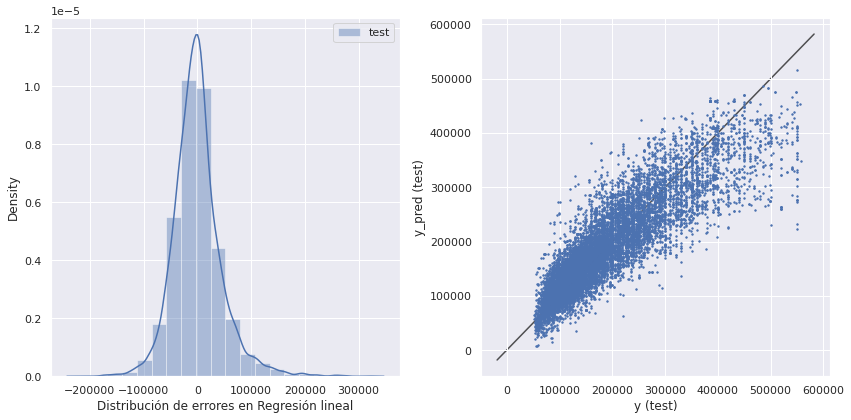

In [179]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
# sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_reg, bins = 20, label = 'test')
plt.xlabel('Distribución de errores en Regresión lineal')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_reg, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

**Distribución de errores para XGBoost**

/home/lulu/anaconda2/envs/datascience/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


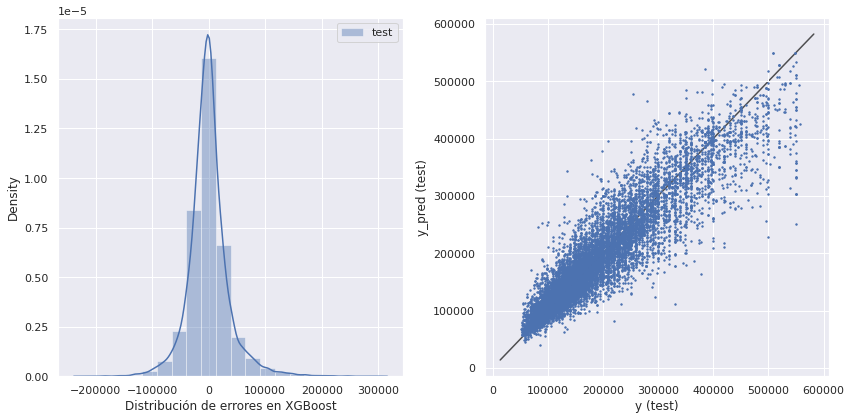

In [180]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
# sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('Distribución de errores en XGBoost')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

Se observa que en ambos modelos la distribución de errores sigue una distribución normal. A medida que aumenta el precio de la propiedad se observa que hay mayor cantidad de discrepancias entre y(test) vs y(predicción), y **la mayor parte de los errores se encuentra en las propiedades de mayor valor**. Este comportamiento no es una sorpresa, ya que en la gráfica de distribución de precios se observaba una distribución con asimetría positiva, mostrando que la cantidad de propiedades con precios muy elevados era baja en comparación al resto, y que los algoritmos van a tener menos datos con los que entrenarse.   


En una comparación visual de ambas gráficas, podemos ver que el modelo de Regresión lineal tiende a subestimar más los precios que el modelo realizado con XGBoost (en la parte derecha del scatter plot se ve que gran parte de los puntos quedan por debajo de la recta teórica), a comparación del scatter plot del XGBoost en la que los puntos se distribuyen más homogéneamente por arriba y por debajo de la recta.

Observando los histogramas, vemos que en XGBoost los errores presentan menos dispersión que en la Regresión lineal (vemos un histograma más estrecho y con un pico más alto en el bin central en XGBoost, a comparación de un histograma un poco más ensanchado para la Regresión Lineal). Esto revela que la magnitud de los errores cometidos por XGBoost es menor que por la Regresión lineal. 

#### **2- Variables de relevancia para el modelo**

Observando las **matrices de correlación** de la Parte B, podemos ver que las variables que presentan mayor correlación con el precio son surface_total y surface_covered, por sobre otros predictores como rooms, bedrooms y bathrooms. 

[0.00214901 0.00601735 0.03001441 0.03261254 0.03235821 0.00127477
 0.02908684 0.00650494 0.00247328 0.00051655 0.01274727 0.01589908
 0.00368205 0.03626472 0.05443331 0.01271469 0.00401063 0.00485137
 0.00070249 0.00403342 0.00202109 0.00803394 0.00985116 0.01575554
 0.02062193 0.01174209 0.01845687 0.04087337 0.00437557 0.01184952
 0.00985348 0.00571352 0.04042699 0.03500366 0.05967682 0.00916255
 0.00503012 0.00615885 0.00122086 0.00634162 0.00380544 0.01765792
 0.16994227 0.0441363  0.00638699 0.00344457 0.01681363 0.0089836
 0.00233242 0.00448393 0.00292559 0.00331587 0.00570679 0.00253684
 0.00400346 0.05183453 0.0031911  0.00236358 0.00098099 0.00108078
 0.00223341 0.00225963 0.00666698 0.01617408 0.00222284]


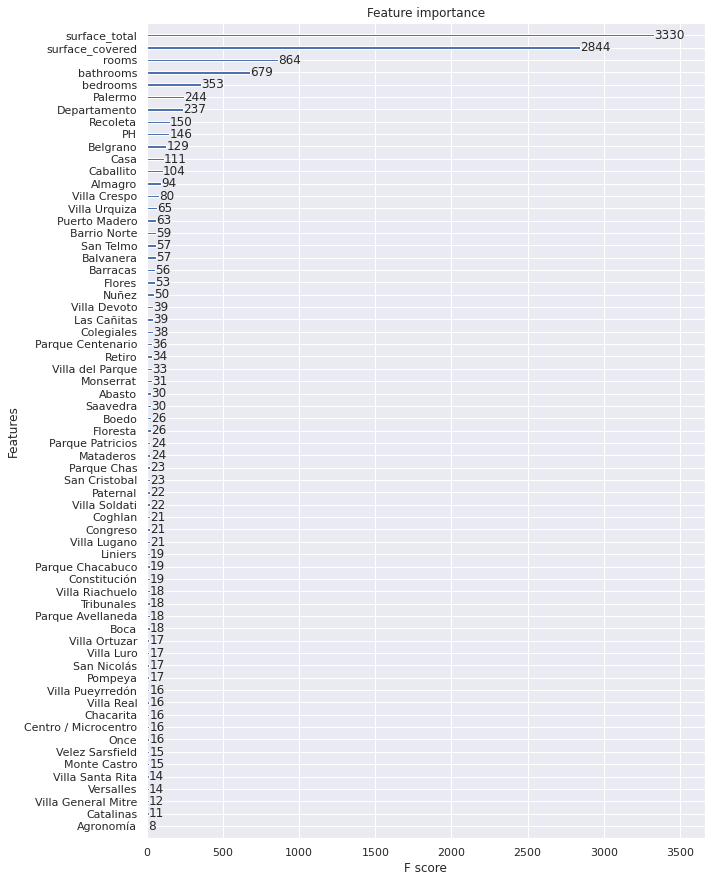

In [181]:
print(xg_reg.feature_importances_)

from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (10, 15)
plot_importance(xg_reg)
plt.show()

Analizo la importancia de los features para XGBoost que es el modelo con mejor performance obtenida. En este modelo, los atributos que poseen mayor relevancia para el modelo, en orden descendente, son: **surface_total, surface_covered, rooms, bathrooms, bedrooms**. Algunos barrios se presentan como de relevancia para la predicción, como Palermo, Belgrano, Recoleta, Caballito o Villa Crespo (barrios de zona norte o centro de la Ciudad) y el tipo de propiedad también se encuentra de los predictores más importantes.

En el Proyecto 1 se había mostrado que había diferencia entre los precios medios según el barrio en la Capital Federal, con lo cual aportar dicha variable ayuda a mejorar la performance, sobre todo en barrios con mayor cantidad de propiedades. 

Como era de esperar, el tipo de propiedad también es un atributo relevante para la estimación de los precios.

Los atributos mencionados coinciden con lo esperado como mejores predictores para este dataset.

### <font color=red>**Parte D (Agregado): Evaluación del impacto de la reducción de dimensionalidad sobre el modelo**</font> 

In [255]:
df5 = pd.read_csv('df_parteb.csv')
df5.head()
df5.shape

(69017, 66)

In [256]:
X = df4.drop('price', axis=1)
y = df4.price

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [258]:
# Reduzco la dimensionalidad conservando el 95% de la varianza total
pca = PCA(.95)  
train_pca = pca.fit_transform(X_train)
test_pca = pca.transform(X_test)

#Número de componentes principales que retienen el 95% de la varianza y la el porcentaje de varianza explicado por cada uno
print(pca.n_components_)
print(pca.explained_variance_)

57
[4.08214414 2.02569748 1.1636944  1.12094103 1.09146806 1.08034859
 1.07563871 1.0666428  1.05121491 1.04423361 1.03498096 1.03004155
 1.02674799 1.02299862 1.02034932 1.01689943 1.01561423 1.01404947
 1.01278163 1.0125791  1.01226448 1.01189511 1.01142043 1.01012665
 1.00945346 1.00942716 1.00908048 1.00898249 1.00870456 1.00837063
 1.00823463 1.00803143 1.007905   1.00758317 1.00687253 1.00656368
 1.00651722 1.00637846 1.00601706 1.00533216 1.00487793 1.00464805
 1.00429348 1.00406163 1.00376484 1.00358248 1.00325013 1.00263738
 1.00234573 1.00220791 1.00212053 1.00182944 1.0016367  1.00085546
 1.00053705 1.0001421  0.98754031]


In [264]:
print(pca.explained_variance_ratio_)

[0.06280108 0.03116401 0.01790267 0.01724493 0.01679151 0.01662045
 0.01654799 0.01640959 0.01617224 0.01606484 0.0159225  0.01584651
 0.01579584 0.01573816 0.0156974  0.01564432 0.01562455 0.01560048
 0.01558097 0.01557786 0.01557302 0.01556734 0.01556003 0.01554013
 0.01552977 0.01552937 0.01552403 0.01552253 0.01551825 0.01551311
 0.01551102 0.01550789 0.01550595 0.015501   0.01549007 0.01548531
 0.0154846  0.01548247 0.01547691 0.01546637 0.01545938 0.01545584
 0.01545039 0.01544682 0.01544226 0.01543945 0.01543434 0.01542491
 0.01542042 0.0154183  0.01541696 0.01541248 0.01540952 0.0153975
 0.0153926  0.01538652 0.01519265]


In [265]:
t0 = time()
# Defino el modelo
xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Validación cruzada
xg_cv = cross_val_score(xg_reg, train_pca, y_train, cv=5, scoring='r2')
print(xg_cv)

# Entreno el modelo
xg_reg.fit(train_pca,y_train)

# Realizo las predicciones
y_test_pred = xg_reg.predict(test_pca)
y_train_pred = xg_reg.predict(train_pca)

# Evalúo las predicciones
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print('')
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

fit_time = time() - t0
print('Tiempo consumido:', fit_time)

[0.86237125 0.85554754 0.85362592 0.86503189 0.85845431]

Raíz del error cuadrático medio en Train: 29188.3549910273
Raíz del error cuadrático medio en Test: 34649.84804418443
Tiempo consumido: 479.6074769496918


**Conclusiones PCA**

La reducción de dimesionalidad por PCA (Principal Component Analysis) conservando un 95% de la varianza total logra mejorar la performance del modelo XGBoost orginal. No se produce una disminución significativa en el tiempo de procesamiento debido a que el número de atributos pasa de 65 a 57 en la reducción de dimensionalidad y no es tan grande el cambio.Por el contrario, el tiempo de procesamiento aumenta al aplicar PCA. Los dos primeros componentes, PC1 y PC2 explican el 0.06% y 0.03% de la varianza, respectivamente y el porcentaje es menor para el resto de los componentes.

RMSE Árbol de decisión del Proyecto 1 (Test): 107205.71   
RMSE Árbol de decisión del Proyecto 2 (Test): 41295.29  
RMSE Regresión lineal (Test): 45763.87   
RMSE Regresión lineal con atributos polinómicos y regularización (Test): 45692.06  
RMSE XGBoost (Test): 36418.83  
**RMSE XGBoost con reducción de dimensionalidad por PCA (Test): 34649.85**

### <font color=darkviolet>**Conclusiones finales**</font> 

A lo largo del Proyecto 1 y Proyecto 2 se evidenció el fuerte impacto que posee el **preprocesamiento de los datos** y la **optimización de hiperparámetros** sobre el resultado final del modelo.  

Comparando el mismo modelo empleado en el Proyecto 1 (Árbol de decisión, max_depth = 16) con el preprocesamiento de los datos luego de realizar Encoding, Tratamiento de outliers, Eliminación de valores faltantes y Escalado de datos se observa una disminución del RMSE en test a más de la mitad (de 107205.71 a 41295.29).   

Se puede ver que no todos los modelos avanzados son mejores que los modelos más simples vistos en el Sprint 1, por ejemplo, la Regresión lineal con atributos polinómicos no mostró mejoras del Àrbol de decisión del Proyecto 1.

Por otra parte, el empleo de modelos avanzados más sofisticados como **XGBoost** logró mejorar aún más el desempeño del modelo, pasando el RMSE a 33199.71. **XGBoost** fue el modelo que mejor desempeño tuvo con el dataset de Properati en el Proyecto 2, por lo tanto sería el modelo elegido para realizar las predicciones de los precios, a pesar de que no es perfecto y se observa que comete errores tanto de sobreprecio como de subvaloración en los gráficos de errores de la Parte C de este proyecto.

La **reducción de dimensionalidad por PCA previa a la aplicación de XGBoost** mostró mejor performance en el rendimiento en términos de RMSE, pero demanda más tiempo computacional. En el contexto actual, elegiría este último modelo por presentar mejor RMSE y porque el tiempo de corrida del modelo no fue excesivo. 

Para seguir mejorando la performance buscaría optimizar la performance considerando otros aspectos como incorporar nuevos atributos si fuera posible y mayor muestreo de propiedades en barrios con menor cantidad de instancias para lograr un mejor balance. 